# Principled Bayesian Workflow for Van't Hoff Approach

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pystan 
import mwc.viz
import mwc.stats
import tqdm
colors, palette = mwc.viz.plotting_style()

In this notebook, I will follow the principled Bayesian workflow (meaning, prior predictive, sbc, and posterior predictive checks) to calibrate the inference the standard enthalpy and entropy of temperature-dependent repressor-DNA binding affinity. 

The crux of the Van't Hoff equation  is that the derivative of the log equilibrium constant $K_{eq}$ is 
$$
\frac{d \log K_{eq}}{dT} = -\frac{\Delta H}{RT^2} 
$$
where $T$ is the temperature, $\Delta H$ is the standard enthalpy change of hte reaction, and $R$ is the gas constant. This is derived from  thermodynamics in a very straighforward manner. The difference in the Gibbs free energy between states of a reaction is defined as 
$$
\Delta G = \Delta H - T\Delta S 
$$
where $\Delta S$ is the change in entropy. The Gibbs free energy can also be determined from the reaction's equlibrium constant as 
$$
\Delta G = -RT \log K_{eq}.
$$
With these two equations in hand, it is relatively simple to state
$$
\log K_{eq} = -\frac{\Delta H}{RT} + \frac{\Delta S}{R},
$$
which differentiated with respect to temperature yields the Van't Hoff equation stated above. In this work, we consider an effective DNA binding energy $\varepsilon$, which can be expressed in terms of a $K_D$ as 
$$
\Delta\varepsilon = - k_BT \log\frac{K_D}{C_0}.
$$

Thus, we can state that the effective DNA binding energy $\Delta\varepsilon$ is related to the enthalpy and entropy as 
$$
\Delta\varepsilon = \frac{\Delta H}{N_A k_BT} - \frac{\Delta S}{N_A k_B},
$$
where $N_A$ is Avogadro's number and $k_B$ is the Boltzmann constant. 

## Building a Statistical Model

For each temperature, we have made a set of $N$ fold-change measurements $\bf{fc}$. Our thermodynamic model states that at a given temperature, the fold-change in gene expression becomes
$$
\text{fold-change} = \frac{1}{1 + \frac{R}{N_{NS}}e^{-\beta\Delta\varepsilon}},
$$
where $R$ is the repressor copy number, $N_{NS}$ is the number of nonspecific binding sites, and $\Delta\varepsilon$ is the effective DNA binding energy defined as 
$$
\Delta\varepsilon = \Delta\varepsilon_{RA} - k_BT \log\left(1 + e^{-\beta\Delta\varepsilon_{AI}}\right),
$$
where $\Delta\varepsilon_{RA}$ and $\Delta\varepsilon_{AI}$ are the active repressor DNA binding energy and the active/inactive repressor energetic difference, respectively. 

Thus, for each temperature, we are interested in estimating the effective DNA binding energy, standard enthalpy change, and standard entropy change. Via Bayes' theorem, we can state this mathematically as 
$$
g(\Delta G, \Delta S, \sigma \, \vert\, \mathbf{fc}, R, N_{NS}, T) \propto f(\mathbf{fc} \, \vert\, R, N_{NS}, T, \Delta G, \Delta S, \sigma)g(\Delta G)g(\Delta S)g(\sigma)
$$
where $\sigma$ is the homoscedastic error. 

The likelihood, as we typically do, can take the form of a Gaussian distribution, though we perform the estimate on the log fold-change as the quantity is defined on a logarithmic scale. We are now tasked with defining the functional forms of the prior probability distributions. As we typically do, we take the prior on $\sigma$ to be 
$$
g(s) \sim \text{HalfNormal}(0.1)
$$
which he have shown previously to be a reasonable prior. We are now tasked with choosing priors for $\Delta G$ and $\Delta S$. 

In [45]:
# Perform prior predictive checks. 
rep_range = np.logspace(0, 3, 5)
temps = [32, 37, 42]

# Define the priors
delH_mu, delH_sigma = 4.5, 2
delS_mu, delS_sigma = 2, 1
sigma_mu, sigma_sigma = 0, 0.1

# Define the number of simulations 
n_sim = 1000
n_draws = 6

# Instantiate the storage dataframe.
dfs = []
for sim in tqdm.tqdm(range(n_sim)):
    #Draw random values for the delG and delS
    delH = np.random.lognormal(delH_mu, delH_sigma)
    delS = np.random.lognormal(delS_mu, delS_sigma)
    sigma = np.abs(np.random.normal(sigma_mu, sigma_sigma))
    for t in temps:
        epsilon = (delH / (t + 273.15)) - delS
        for j, r in enumerate(rep_range):
            # Compute the mean fold-change
            fc_mu = -1 * np.log(1 + (r /  4.6E6) * np.exp(-epsilon))
            draws = np.random.normal(fc_mu, sigma, n_draws)

            # Create a dataframe and store everything. 
            _df = pd.DataFrame([])
            _df['fc_draw'] = np.exp(draws)
            _df['sim'] = sim
            _df['repressors'] = r
            _df['temp_C'] = t
            _df['epsilon'] = epsilon
            _df['delH'] = delH
            _df['delS'] = delS
            dfs.append(_df)
prior_pred_df = pd.concat(dfs, sort=False)

100%|██████████| 1000/1000 [01:04<00:00, 15.56it/s]


In [46]:
# Group by the sim and repressor number and compute the mean, then plot
perc_df = pd.DataFrame([])
for g, d in prior_pred_df.groupby(['repressors', 'temp_C']):
    for up, down, lab in zip([0.5, 2.5, 5, 12.5, 45],
                             [99.5, 97.5, 95, 87.5, 55],
                             ['99', '95', '90', '75', '50']):
        low, high = np.percentile(d['fc_draw'], (up, down))
        perc_df = perc_df.append({'lower':low,
                                  'upper':high,
                                  'percentile': lab,
                                  'repressors': g[0],
                                  'temp_C': g[1]},
                                  ignore_index=True)

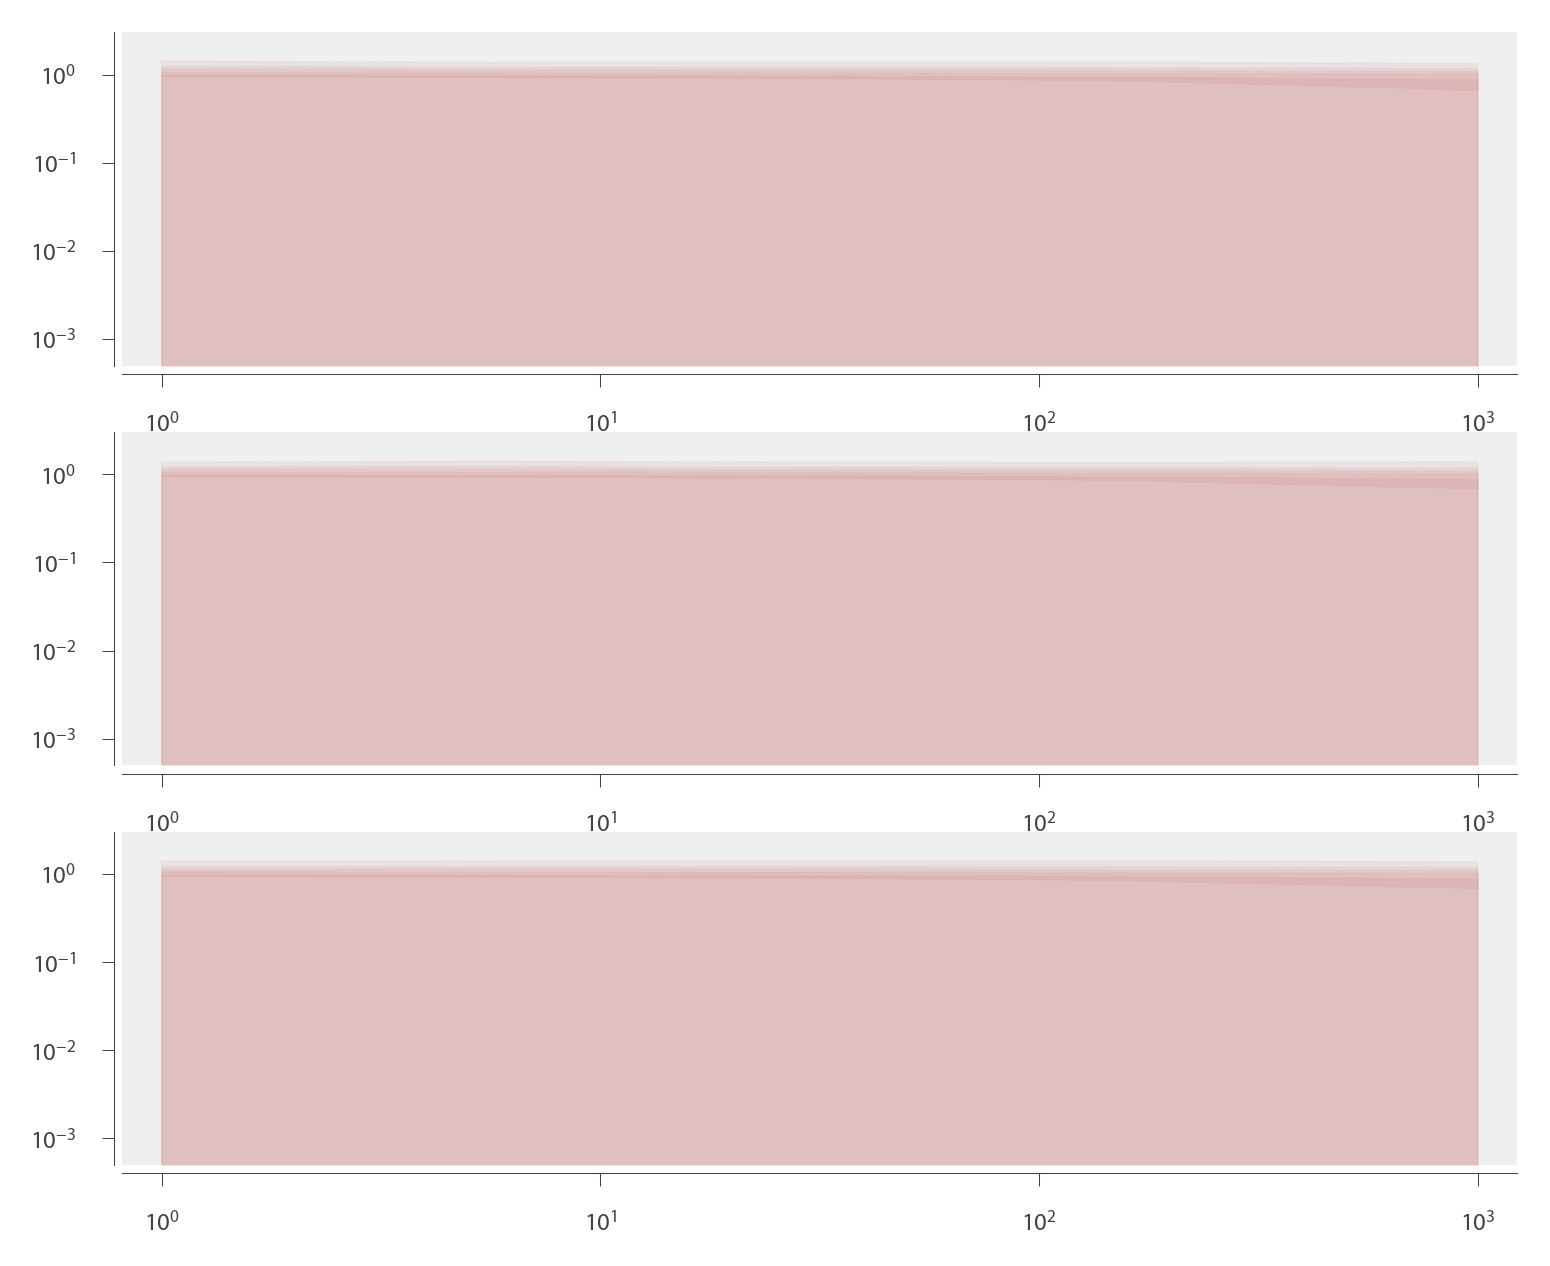

In [47]:
fig, ax = plt.subplots(3, 1, figsize=(6, 5))
mwc.viz.despine(ax)
for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_ylim([5E-4, 3])
temp_ax = {32:ax[0], 37:ax[1], 42:ax[2]}
for g, d in perc_df.groupby(['percentile', 'temp_C']):
    temp_ax[g[1]].fill_between(d['repressors'], d['lower'], d['upper'], color=colors['red'], alpha=0.1)

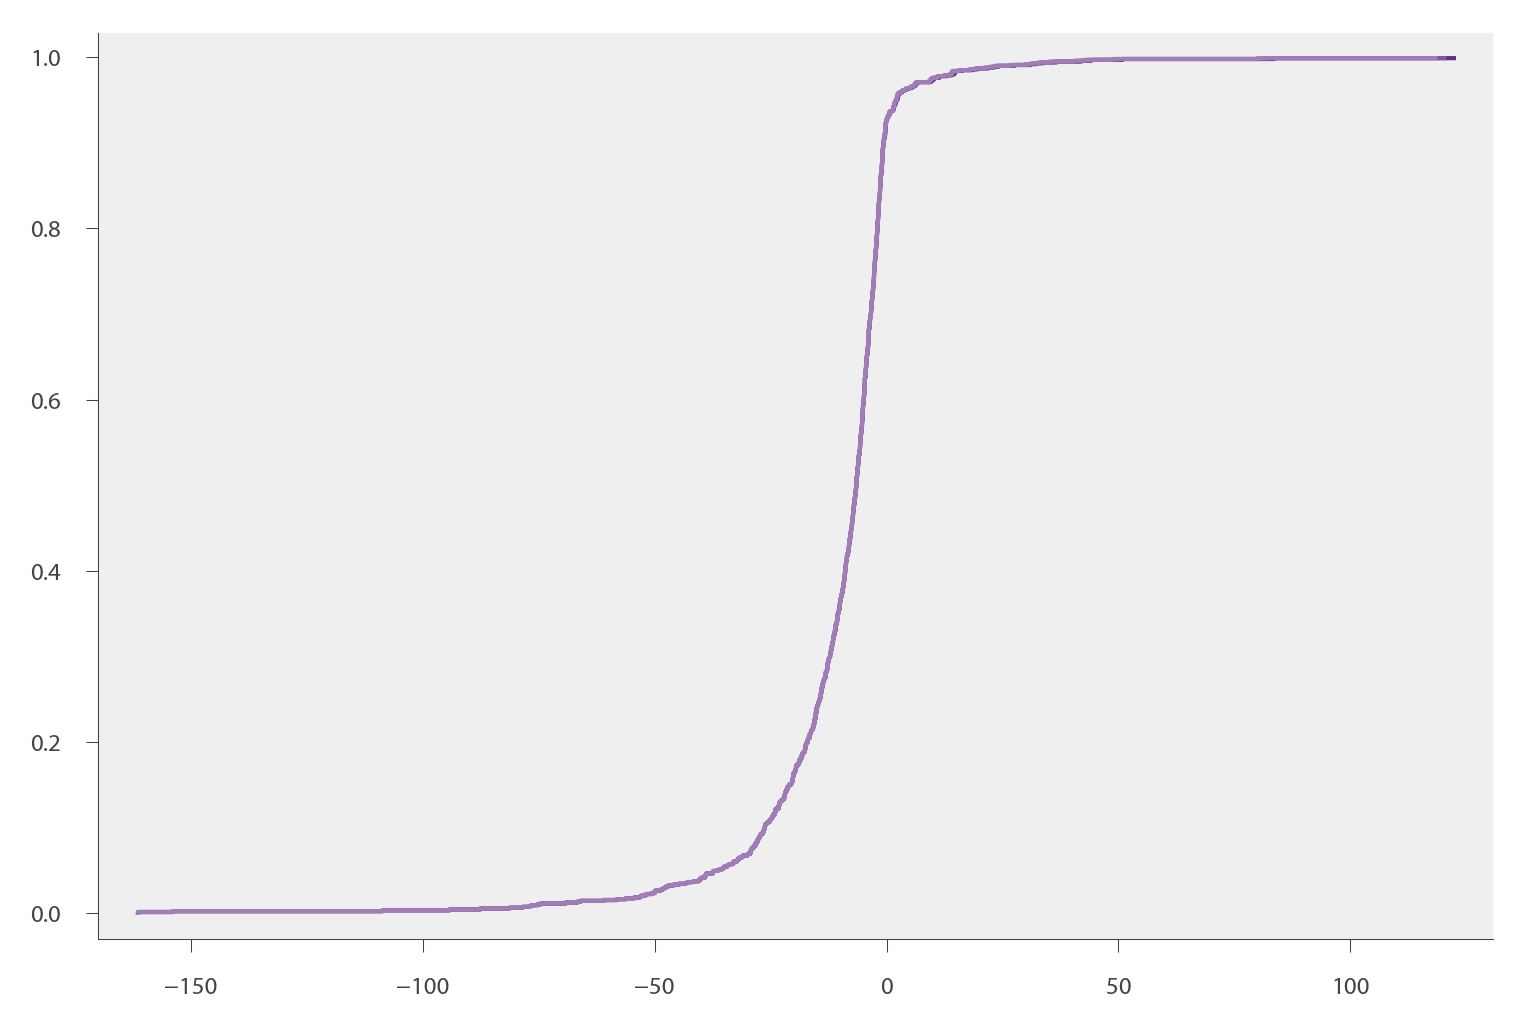

In [49]:
bins = np.linspace(-20, 5, 75)
fig, ax = plt.subplots(1, 1)
y = np.arange(0, n_sim, 1) / n_sim
_ = ax.step(np.sort(prior_pred_df[(prior_pred_df['temp_C']==32)]['epsilon'].unique()), y, lw=1)
_ = ax.step(np.sort(prior_pred_df[(prior_pred_df['temp_C']==37)]['epsilon'].unique()), y, lw=1)
_ = ax.step(np.sort(prior_pred_df[(prior_pred_df['temp_C']==42)]['epsilon'].unique()), y, lw=1)
